In [67]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [68]:
#reading all the words
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [69]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [70]:
#building data sets

def build_dataset(words):
    block_size = 3 #how many characters we take to predict the next one
    X, Y  = [], []
    
    for w in words:
        
        context = [0] * block_size 
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape , Y.shape)
    return X , Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words)) 

# spltiting the data to training split, dev/validation, test split
Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [71]:
#------------------- parameters ---------------------------

g = torch.Generator().manual_seed(214748364)
sdim = 10
vs = 3 * sdim
C = torch.randn((27,sdim), generator=g)
W1 = torch.randn((vs,300), generator=g)
B1 = torch.randn((300), generator=g)
W2 = torch.randn((300,27), generator=g)
B2 = torch.randn((27), generator=g)
param = [C, W1, B1, W2, B2]

for p in param:
    p.requires_grad = True 

In [72]:
sum(p.nelement() for p in param) #amount of parameters (neurons)

17697

In [73]:
#looking for learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

#arrays to store the loss and learning rates to plot later
lri = []
lossi = []
stepi = []

In [74]:
for i in range(100000):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    #forward pass
    emb = C[Xtr[ix]] #we index here with the entire inputs to get a new tensor with probabilty #squishing it 
    h = torch.tanh(emb.view(-1, vs) @ W1 + B1)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, Ytr[ix])

    #backward pass
    for p in param:
        p.grad = None
    loss.backward()

    #update
#     lr = lrs[i]
    #lr = 10**(-1.1) if i < 100000 else (10**(-1.1)/10)
    lr = 0.1
    for p in param:
        p.data += -lr/10 * p.grad
    
#     #track stats
#     lri.append(lre[i]) #using the exp of the lr
    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(loss.item())

2.19205641746521


In [52]:
#checking train loss if they are equal means the neural network is too small and we are underfitting

emb = C[Xtr] 
h = torch.tanh(emb.view(-1, vs) @ W1 + B1)
logits = (h @ W2) + B2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2956, grad_fn=<NllLossBackward0>)

In [53]:
#checking dev loss

emb = C[Xdev]
h = torch.tanh(emb.view(-1, vs) @ W1 + B1)
logits = (h @ W2) + B2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2911, grad_fn=<NllLossBackward0>)

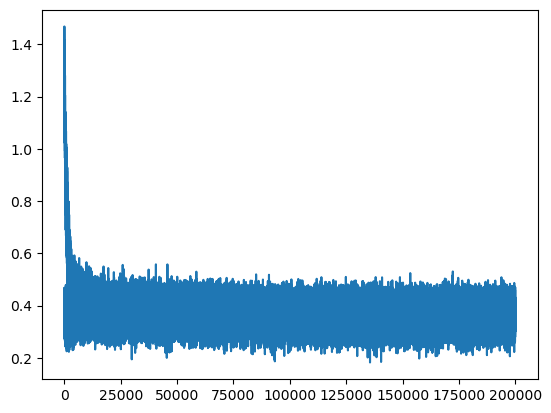

In [30]:
plt.plot(stepi, lossi)

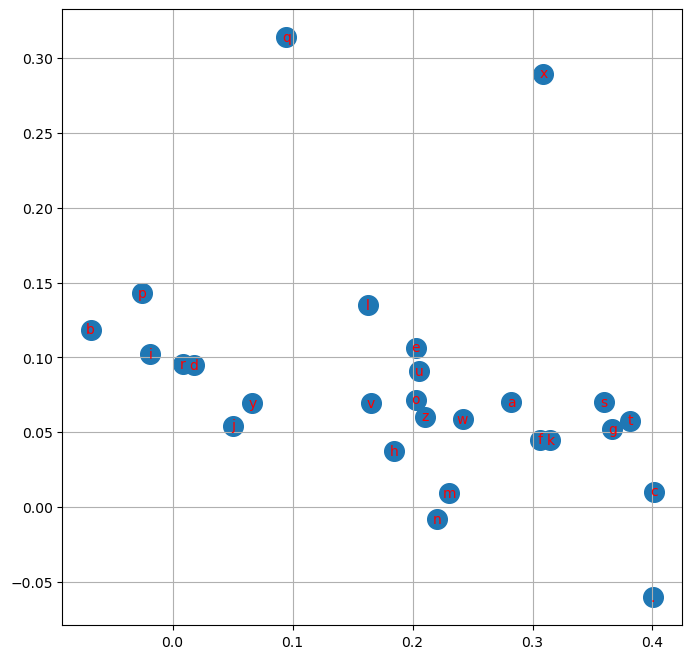

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="red")
plt.grid('minor')